In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import talib 
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression



In [79]:
startdate = '2017-01-1'
enddate= '2021-12-31'
scaler = MinMaxScaler()

In [235]:
dji = pdr.get_data_yahoo('^DJI', start=startdate, end=enddate)
dji_norm = pd.DataFrame(scaler.fit_transform(dji), columns=dji.columns)
n225 = pdr.get_data_yahoo("^N225", start=startdate, end=enddate)
n225_norm = pd.DataFrame(scaler.fit_transform(n225), columns=n225.columns)
hsi = pdr.get_data_yahoo("^HSI", start=startdate, end=enddate)
hsi_norm = pd.DataFrame(scaler.fit_transform(hsi), columns=hsi.columns)
sse = pdr.get_data_yahoo("000001.SS", start=startdate, end=enddate)
sse_norm = pd.DataFrame(scaler.fit_transform(sse), columns=sse.columns)


In [285]:
dji['Future Close'] = dji['Close'].shift(-1)
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2017-01-03,19938.529297,19775.929688,19872.859375,19881.759766,339180000,19881.759766,19942.160156
2017-01-04,19956.140625,19878.830078,19890.939453,19942.160156,280010000,19942.160156,19899.289062
2017-01-05,19948.599609,19811.119141,19924.560547,19899.289062,269920000,19899.289062,19963.800781
2017-01-06,19999.630859,19834.080078,19906.960938,19963.800781,277700000,19963.800781,19887.380859
2017-01-09,19943.779297,19887.380859,19931.410156,19887.380859,287510000,19887.380859,19855.529297
...,...,...,...,...,...,...,...
2021-11-15,36236.070312,36031.781250,36128.828125,36087.449219,280660000,36087.449219,36142.218750
2021-11-16,36316.609375,36076.179688,36076.179688,36142.218750,308290000,36142.218750,35931.050781
2021-11-17,36159.699219,35909.480469,36159.699219,35931.050781,358310000,35931.050781,35870.949219


In [286]:
def computeTarget(present_price, future_price):
    score = (( future_price - present_price ) / present_price ) * 100
    target = []
    for i in score:
        if i > 0.05:
            target.append(1)
        elif i < -0.05:
            target.append(0)
        else:
            target.append(2)
    return target
# 2 = up, 1 = down, 0 = sideway

In [287]:

target = computeTarget(dji['Close'], dji['Future Close'])

dji['Target'] = target
dji = dji.dropna()

In [288]:
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close,Target
Date,,,,,,,,
2017-01-03,19938.529297,19775.929688,19872.859375,19881.759766,339180000,19881.759766,19942.160156,1
2017-01-04,19956.140625,19878.830078,19890.939453,19942.160156,280010000,19942.160156,19899.289062,0
2017-01-05,19948.599609,19811.119141,19924.560547,19899.289062,269920000,19899.289062,19963.800781,1
2017-01-06,19999.630859,19834.080078,19906.960938,19963.800781,277700000,19963.800781,19887.380859,0
2017-01-09,19943.779297,19887.380859,19931.410156,19887.380859,287510000,19887.380859,19855.529297,0
...,...,...,...,...,...,...,...,...
2021-11-12,36147.628906,35934.589844,35963.781250,36100.308594,293180000,36100.308594,36087.449219,2
2021-11-15,36236.070312,36031.781250,36128.828125,36087.449219,280660000,36087.449219,36142.218750,1
2021-11-16,36316.609375,36076.179688,36076.179688,36142.218750,308290000,36142.218750,35931.050781,0


In [301]:
close = dji['Close']
high = dji['High']
low = dji['Low']
open = dji['Open']
volume  = dji['Volume']

In [309]:
ti = dji.copy()
ti['SMA20'] = talib.SMA(close, timeperiod=20)
ti['SMA50'] = talib.SMA(close, timeperiod=50)
ti['SMA200'] = talib.SMA(close, timeperiod=200)
ti['EMA'] = talib.EMA(close, timeperiod=14)
ti['OBV'] = talib.OBV(close, volume)
ti['RSI14'] = talib.RSI(close, timeperiod=14)
ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
ti['aroondown'], ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
ti['BOP'] = talib.BOP(open, high, low, close)
ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
ti['CMO'] = talib.CMO(close, timeperiod=14)
ti['DX'] = talib.DX(high, low, close, timeperiod=14)
ti['macd'],ti['macdsignal'],ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
ti['MOM'] = talib.MOM(close, timeperiod=14)
ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
ti['ROC'] = talib.ROC(close, timeperiod=10)
ti['ROCP'] = talib.ROCP(close, timeperiod=10)
ti['ROCR'] = talib.ROCR(close, timeperiod=10)
ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
ti['slowk'], ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
ti['fastk'], ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
ti['TRIX'] = talib.TRIX(close, timeperiod=30)
ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
ti['Target'] = dji['Target']
ti

,High,Low,Open,Close,Volume,Adj Close,Future Close,Target,SMA20,SMA50,...,ROCP,ROCR,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,19938.529297,19775.929688,19872.859375,19881.759766,339180000,19881.759766,19942.160156,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,19956.140625,19878.830078,19890.939453,19942.160156,280010000,19942.160156,19899.289062,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,19948.599609,19811.119141,19924.560547,19899.289062,269920000,19899.289062,19963.800781,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,19999.630859,19834.080078,19906.960938,19963.800781,277700000,19963.800781,19887.380859,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,19943.779297,19887.380859,19931.410156,19887.380859,287510000,19887.380859,19855.529297,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-12,36147.628906,35934.589844,35963.781250,36100.308594,293180000,36100.308594,36087.449219,2,35878.700977,35105.925547,...,0.007838,1.007838,100.783790,15.166204,31.797097,28.447375,15.166204,0.045709,51.125760,-43.282948
2021-11-15,36236.070312,36031.781250,36128.828125,36087.449219,280660000,36087.449219,36142.218750,1,35920.142969,35120.292734,...,0.004834,1.004834,100.483405,21.227432,21.085635,34.318504,21.227432,0.048812,47.777185,-44.478834
2021-11-16,36316.609375,36076.179688,36076.179688,36142.218750,308290000,36142.218750,35931.050781,0,35954.388477,35141.137109,...,0.002485,1.002485,100.248497,38.460274,24.951303,52.614944,38.460274,0.051693,45.702226,-41.507722


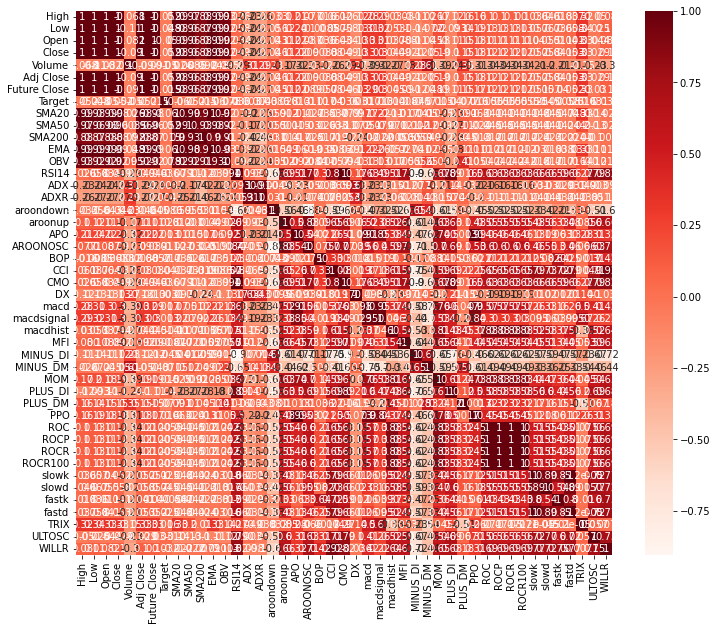

In [310]:
plt.figure(figsize=(12,10))
cor = ti.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [311]:
cor_target = abs(cor["Target"])
features = cor_target[cor_target>0]
features

High            0.051617
Low             0.048325
Open            0.049658
Close           0.051581
Volume          0.050024
Adj Close       0.051581
Future Close    0.014931
Target          1.000000
SMA20           0.059973
SMA50           0.051875
SMA200          0.014663
EMA             0.059858
OBV             0.078341
RSI14           0.036193
ADX             0.003731
ADXR            0.004284
aroondown       0.008610
aroonup         0.028354
APO             0.013219
AROONOSC        0.011154
BOP             0.016928
CCI             0.040398
CMO             0.036193
DX              0.003096
macd            0.016669
macdsignal      0.012963
macdhist        0.014133
MFI             0.000870
MINUS_DI        0.044684
MINUS_DM        0.071470
MOM             0.015434
PLUS_DI         0.039805
PLUS_DM         0.076659
PPO             0.015558
ROC             0.005525
ROCP            0.005525
ROCR            0.005525
ROCR100         0.005525
slowk           0.025252
slowd           0.045476


In [303]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable
y

Date
2017-10-17    1
2017-10-18    2
2017-10-19    1
2017-10-20    0
2017-10-23    1
             ..
2021-11-12    2
2021-11-15    1
2021-11-16    0
2021-11-17    0
2021-11-18    0
Name: Target, Length: 1031, dtype: int64

In [304]:
X = X.fillna(0)

In [305]:
X.isna().sum()

SMA20         0
SMA50         0
SMA200        0
EMA           0
OBV           0
RSI14         0
ADX           0
ADXR          0
aroondown     0
aroonup       0
APO           0
AROONOSC      0
BOP           0
CCI           0
CMO           0
DX            0
macd          0
macdsignal    0
macdhist      0
MFI           0
MINUS_DI      0
MINUS_DM      0
MOM           0
PLUS_DI       0
PLUS_DM       0
PPO           0
ROC           0
ROCP          0
ROCR          0
ROCR100       0
slowk         0
slowd         0
fastk         0
fastd         0
TRIX          0
ULTOSC        0
WILLR         0
dtype: int64

In [306]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, n_features_to_select=7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)

print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
  True False False False False False False False  True False False  True
 False False  True False False  True False False False False  True  True
 False]
[22 23 29 30 31  7 19  6  9 12 24 11  1 16  2 10 17 18 14  4  1 21 28  1
 20  3  1 26 25  1 15 27  8 13  1  1  5]


In [307]:
# no. of features
#
nof_list = np.arange(1, 13)            
high_score = 0

# Variable to store the optimum features
#
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)

    score = model.score(X_test_rfe,y_test)
    score_list.append(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.001347


In [308]:
cols = list(X.columns)
model = LinearRegression()

# Initializing RFE model
rfe = RFE(model, n_features_to_select=10)             

# Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

# Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['BOP', 'CMO', 'MFI', 'MINUS_DI', 'PLUS_DI', 'PPO', 'ROC', 'ROCR100',
       'TRIX', 'ULTOSC'],
      dtype='object')


In [299]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable
#Split the features and target data
#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
sfs.fit(X, y)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results


,feature_idx,cv_scores,avg_score,feature_names
1,"(31,)",[0.002245631195525899],0.002246,"(slowd,)"
2,"(24, 31)",[0.005248917307515866],0.005249,"(PLUS_DM, slowd)"
3,"(8, 24, 31)",[0.006166136954210311],0.006166,"(aroondown, PLUS_DM, slowd)"
4,"(8, 20, 24, 31)",[0.007505082886635539],0.007505,"(aroondown, MINUS_DI, PLUS_DM, slowd)"
5,"(8, 12, 20, 24, 31)",[0.0088527180869592],0.008853,"(aroondown, BOP, MINUS_DI, PLUS_DM, slowd)"


In [300]:
ti = ti.dropna()
X = ti.drop("Target", axis=1)  # Feature Matrix
y = ti["Target"]               # Target Variable

sffs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=True,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
feature_names=ti.columns
sffs.fit(X, y,)

#Create a dataframe for the SFS results 
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(31,)",[0.002245631195525899],0.002246,"(slowd,)"
2,"(24, 31)",[0.005248917307515866],0.005249,"(PLUS_DM, slowd)"
3,"(8, 24, 31)",[0.006166136954210311],0.006166,"(aroondown, PLUS_DM, slowd)"
4,"(8, 20, 24, 31)",[0.007505082886635539],0.007505,"(aroondown, MINUS_DI, PLUS_DM, slowd)"
5,"(8, 12, 20, 24, 31)",[0.0088527180869592],0.008853,"(aroondown, BOP, MINUS_DI, PLUS_DM, slowd)"


<h2>จากการทำ Feature Selection ควรจะใช้ RSI14, APO, CMO, macd, macdsignal, MINUS_DI, MINUS_DM, MOM, PLUS_DI, PPO, ROC, ROCP, ROCP, ROCR100 ในการสร้าง model</h2>

In [268]:
from sklearn.model_selection import train_test_split
X = [dji.loc[:, ['High', 'Low', 'Open', 'Close', 'Adj Close']]]
y = [ti.loc[:, ['ADX', 'ADXR', 'BOP', 'MFI', 'MINUS_DI', 'PLUS_DI', 'ROC', 'ROCR100', 'slowd', 'TRIX']]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0)

ValueError: With n_samples=1, test_size=0.2 and train_size=0.8, the resulting train set will be empty. Adjust any of the aforementioned parameters.